# WEST ICRH Antenna Coupling to Water Load
In this notebook, the WEST ICRH antenna is tested against a water load, as performed during the antennas commissioning

<img src="West_Antenna_water_load.png"/>

The distance between the antenna front face and the water tank can be varied. This distance is identified as $D_{aq}$ in the following.

The front-face S-parameter have been calculated in ANYSS HFSS with the antenna front-face facing a salty water load tank of same dimension. The goal is to reproduce and compare the performed measurements. 

In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
from tqdm.notebook import tqdm

import sys; sys.path.append('..')
from west_ic_antenna import WestIcrhAntenna
from west_ic_antenna.topica import TopicaResult

In [4]:
# our frequency band of interest, centred around 55 MHz
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')

In [18]:
# HFSS simulations of the front face facing the water tank
s_dir = '../west_ic_antenna/data/Sparameters/front_faces/aquarium/HFSS/Epsr_55MHz/'
# the distance between the antenna front face and the water tank (Daq)
# goes from 0 to 10 cm 
s_files = [f'WEST_ICRH_front_face_with_aquarium_Daq{idx:02}cm.s4p' for idx in range(0,11)]
# insert free-air radiating case 
s_files.insert(0, 'WEST_ICRH_front_face_with_aquarium_without_aquarium.s4p')

## Water Tank Coupling Resistances
Here we calculate the load resistance of the HFSS simulated wated tank at different distances

In [19]:
power = [1,0]
phase = [0,0]
f_match = 55.0e6
freq = rf.Frequency.from_f(f_match, unit='Hz')

C_matchs = []
for s_file in tqdm(s_files[1:]): # avoid vacuum case
    _ant = WestIcrhAntenna(frequency=freq, front_face=s_dir+s_file)
    C_match = _ant.match_one_side(f_match=f_match, decimals=2) 
    C_matchs.append(C_match)


Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [40.98003248 12.        ]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [52.47309798 46.75672601]
Rounded result: [52.47, 46.76, 150.0, 150.0]
True solution #1: [52.58811018 47.47833167]
Rounded result: [52.59, 47.48, 150.0, 150.0]
True solution #1: [51.91132011 47.24231241]
Rounded result: [51.91, 47.24, 150.0, 150.0]
True solution #1: [51.73828298 47.45685872]
Rounded result: [51.74, 47.46, 150.0, 150.0]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [51.51930113 47.53236774]
Rounded result: [51.52, 47.53, 150.0, 150.0]
True solution #1: [51.3715986  47.62941165]
Rounded result: [51.37, 47.63, 150.0, 150.0]
True solution #1: [51.23687544 47.70961329]
Rounded result: [51.24, 47.71, 150.0, 150.0]
True solution #1: [51.12041374 47.78543004]
Rounded result: [51.12, 47.79, 150.0, 150.0]
Wrong solution (out

In [39]:
# Calculate the coupling resistances for each Daq
# - ideal one (perfect current excitation)
# - from calculated currents
# - from calculated voltage and strap reactance approximation (WEST)
Rcs_ideal = []
Rcs = []
Rcs_WEST = []

for C_match, s_file in zip(C_matchs, s_files[1:]):
    _ant = WestIcrhAntenna(frequency=freq, front_face=s_dir+s_file)
    _ant.Cs = C_match
    
    Rcs.append(_ant.Rc(power, phase))
    Rcs_WEST.append(_ant.Rc_WEST(power, phase))
    Rcs_ideal.append(_ant.front_face_Rc([1,0,-1,0]))

Rcs_ideal = np.array(Rcs_ideal)
Rcs = np.array(Rcs)
Rcs_WEST = np.array(Rcs_WEST)

..\west_ic_antenna\antenna.py:1070: RuntimeWarning: divide by zero encountered in true_divide
  Rc_right = 2*Prf.real/sum_I_right_avg_square


<IPython.core.display.Javascript object>


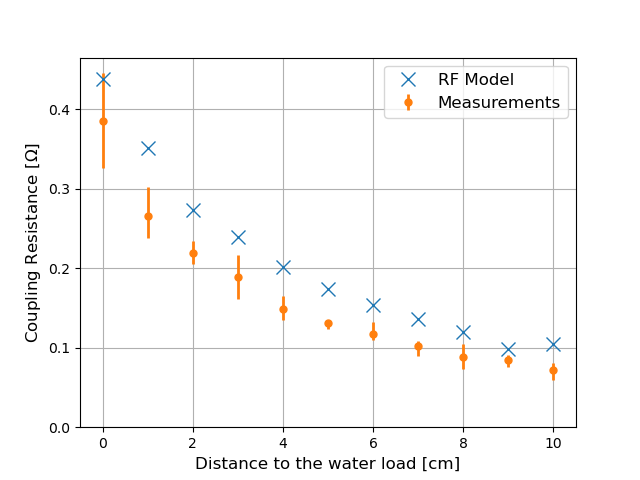

(0.0, 0.4650100425)

In [42]:
# Experimental data
# The antenna is matched for every Daq location
Daq = np.arange(0,11) # Aquarium located from 0 to 10 cm
# each side has two Rcs, from the two solutions
Rcs_left_exp = np.array([[0.44570908, 0.32977295],
       [0.30162864, 0.27882412],
       [0.23385524, 0.22792393],
       [0.21724054, 0.18985918],
       [0.16457068, 0.15533504],
       [0.13515216, 0.13539227],
       [0.13217409, 0.11371388],
       [0.10873666, 0.10804394],
       [0.10417025, 0.09319892],
       [0.09125899, 0.08954157],
       [0.07817165, 0.08120209]])

Rcs_right_exp = np.array([[0.44164593, 0.32560494],
       [0.24493007, 0.23774068],
       [0.20501191, 0.21147719],
       [0.16077201, 0.18748304],
       [0.13497255, 0.14225269],
       [0.12398555, 0.13153104],
       [0.11307492, 0.10982303],
       [0.10211404, 0.08993572],
       [0.07343448, 0.08419643],
       [0.07605827, 0.082465  ],
       [0.07051924, 0.05968983]])

# mean and std
Rcs_exp = np.c_[Rcs_left_exp, Rcs_right_exp]
Rcs_mean_exp = Rcs_exp.mean(axis=1)
Rcs_min = np.amin(Rcs_exp, axis=1)
Rcs_max = np.amax(Rcs_exp, axis=1)

fig, ax = plt.subplots()
#ax.plot(Daq, Rcs_ideal.squeeze()[:,0], '^', ms=10, label='Ideal Currents')
ax.plot(Daq, Rcs.squeeze()[:,0], 'x', ms=10, label='RF Model')
#ax.plot(Daq, Rcs_WEST[:,0], '.')
ax.errorbar(Daq, Rcs_mean_exp, yerr= np.abs(Rcs_mean_exp - np.c_[Rcs_min, Rcs_max].T), 
            marker='o', ls='', ms=5, lw=2, label='Measurements')
#ax.plot(Daq, Rcs_left_exp, 'o')
#ax.plot(Daq, Rcs_right_exp, 'o')
ax.grid(True)
ax.set_xlabel('Distance to the water load [cm]', fontsize=12)
ax.set_ylabel('Coupling Resistance [$\Omega$]', fontsize=12)
ax.legend(fontsize=12)
ax.set_ylim(bottom=0)


## Load Resilience Demonstration
In this example, the antenna is matched for the low and the high coupling case (ie. far from the water load, and close as possible to the water load). Then, the distance to the water load is varied, a situation which demonstrate the load tolerance of the antenna. 

In [24]:
# our frequency band of interest, centred around 55 MHz
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')

# the water tank is removed from the antenna front face: radiating in vacuum
ant_vac_coupling = WestIcrhAntenna(frequency=freq, front_face=s_dir+s_files[0])

# low coupling case: the water tank is far from the antenna 
ant_low_coupling = WestIcrhAntenna(frequency=freq, front_face=s_dir+s_files[-1])

# intermediate case
ant_med_coupling = WestIcrhAntenna(frequency=freq, front_face=s_dir+s_files[5])

# high coupling case: the water tank is as close as possible of the antenna
ant_high_coupling = WestIcrhAntenna(frequency=freq, front_face=s_dir+s_files[1])

For both cases, we match the left side leaving the other side unmatched (could be the opposite). Capacitance values are rounded to 0.01 pF to match the precision which is feasible in reality. 

In [25]:
f_match = 55e6

C_match_vac = ant_vac_coupling.match_one_side(f_match=f_match, side='left', decimals=2)
ant_vac_coupling.Cs = C_match_vac

C_match_low = ant_low_coupling.match_one_side(f_match=f_match, side='left', decimals=2)
ant_low_coupling.Cs = C_match_low

C_match_med = ant_med_coupling.match_one_side(f_match=f_match, side='left', decimals=2)
ant_med_coupling.Cs = C_match_med

C_match_high = ant_high_coupling.match_one_side(f_match=f_match, side='left', decimals=2)
ant_high_coupling.Cs = C_match_high

True solution #1: [50.53093523 48.28995584]
Rounded result: [50.53, 48.29, 150.0, 150.0]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [50.92592983 47.95234541]
Rounded result: [50.93, 47.95, 150.0, 150.0]
True solution #1: [51.51929764 47.53237106]
Rounded result: [51.52, 47.53, 150.0, 150.0]
True solution #1: [52.47311808 46.75670345]
Rounded result: [52.47, 46.76, 150.0, 150.0]


Let's compare the S11 in both case:

<IPython.core.display.Javascript object>


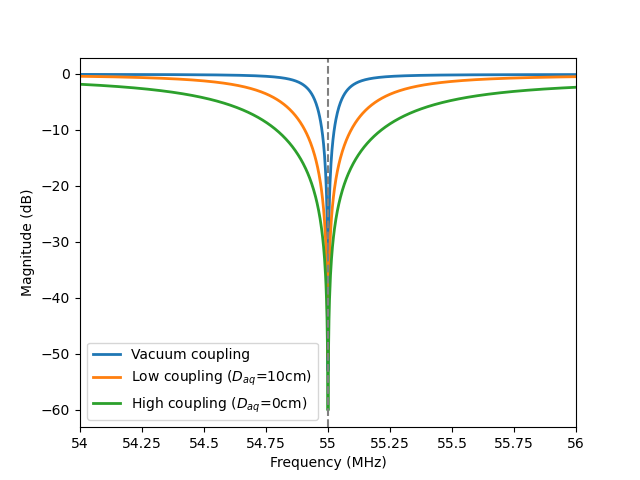

In [26]:
fig, ax = plt.subplots()
ant_vac_coupling.circuit().network.plot_s_db(m=0, n=0, ax=ax, label='Vacuum coupling', lw=2)
ant_low_coupling.circuit().network.plot_s_db(m=0, n=0, ax=ax, label='Low coupling ($D_{aq}$=10cm)', lw=2)
ant_high_coupling.circuit().network.plot_s_db(m=0, n=0, ax=ax, label='High coupling ($D_{aq}$=0cm)', lw=2)
ax.axvline(f_match, color='gray', ls='--')

### Comparing to experiment
Let's assume the antenna is located far away from the water load. Matching the antenna in this condition leads to the following capacitances:

In [27]:
# experimental points (Q4 @ 55.5MHz, left side), solutions 1 & 2
# Match is performed at Daq=10cm, then the aquarium is getting close the antenna
rawdata=np.fromstring('''
1.047217	0.076194
1.053037	0.084361
1.171223	0.086081
1.311482	0.102202
1.485241	0.105474
1.690491	0.135714
1.955233	0.152511
2.271789	0.180029
2.654523	0.25514
3.119218	0.269926
3.828513	0.493614
''', sep='\t')
VSWRs_exp_left1 = rawdata[0::2]
Rcs_exp_left1 = rawdata[1::2]

rawdata=np.fromstring('''
1.001733	0.072035
1.091809	0.078559
1.215506	0.093173
1.362991	0.098416
1.545197	0.132754
1.766289	0.154276
2.031648	0.147267
2.36173	0.193455
2.760997	0.222047
3.225185	0.325237
3.908539	0.348199
3.943449	0.361602
''', sep='\t')
VSWRs_exp_left2 = rawdata[0::2]
Rcs_exp_left2 = rawdata[1::2]

# experimental points (Q4 @ 55.5MHz, right side), solutions 1 & 2
rawdata=np.fromstring('''
1.031294	0.068731
1.160923	0.078213
1.261514	0.093752
1.413696	0.085198
1.603711	0.119953
1.831484	0.123037
2.113948	0.165239
2.447562	0.174803
2.861009	0.268934
3.355778	0.23583
4.052531	0.373618
''', sep='\t')
VSWRs_exp_right1 = rawdata[0::2]
Rcs_exp_right1 = rawdata[1::2]

rawdata=np.fromstring('''
1.031513	0.076441
1.064087	0.072986
1.180435	0.077509
1.326968	0.100891
1.502117	0.119081
1.718699	0.155228
2.019637	0.133187
2.368629	0.184002
2.769505	0.247356
3.239735	0.269681
3.750716	0.34547
''', sep='\t')
VSWRs_exp_right2 = rawdata[0::2]
Rcs_exp_right2 = rawdata[1::2]

In [28]:
# combine measurements
VSWRs_exp = np.concatenate([VSWRs_exp_left1, VSWRs_exp_left2, VSWRs_exp_right1, VSWRs_exp_right2])
Rcs_exp = np.concatenate([Rcs_exp_left1, Rcs_exp_left2, Rcs_exp_right1, Rcs_exp_right2])

In [29]:
# dummy power and phase array since only one side is monitored
f_match = 55.5e6
power = [1, 0]
phase = [0, 0]
freq = rf.Frequency.from_f(f_match, unit='Hz')
ant = WestIcrhAntenna(frequency=freq)
ant.load(Rc=0.05)
C_match_sol1 = ant.match_one_side(f_match=f_match, solution_number=1, side='left')
print(ant)

Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [50.95102531 48.75242359]
WEST ICRH Antenna: C=[50, 50, 50, 50] pF, 55500000.0-55500000.0 Hz, 1 pts


Then, let's move (virtually here) the water load closer and closer to the antenna. For each step, we save the VSWR and the front face Rc and then compare to experimental data

In [30]:
VSWR, Rcs = [], []
for Rc in tqdm(Rcs_exp):
    _ant = WestIcrhAntenna(frequency=freq)
    _ant.load(Rc)
    _ant.Cs = C_match_sol1
    _VSWR = _ant.vswr_act(power, phase)
    _Rcs = _ant.Rc(power, phase)
    VSWR.append(_VSWR)
    Rcs.append(_Rcs)
VSWR_vac = np.array(VSWR).squeeze()
Rcs_vac = np.array(Rcs).squeeze()


C:\Users\JH218595\Documents\scikit-rf\skrf\network.py:6069: RuntimeWarning: divide by zero encountered in true_divide
  s_act[fidx] = npy.matmul(s[fidx], a) / a
C:\Users\JH218595\Documents\scikit-rf\skrf\network.py:6069: RuntimeWarning: invalid value encountered in true_divide
  s_act[fidx] = npy.matmul(s[fidx], a) / a
..\west_ic_antenna\antenna.py:809: RuntimeWarning: invalid value encountered in true_divide
  vswr_right = (1 + np.abs(s_act[:,1]))/(1 - np.abs(s_act[:,1]))
..\west_ic_antenna\antenna.py:939: RuntimeWarning: invalid value encountered in multiply
  return power*np.abs(s_act)**2


<IPython.core.display.Javascript object>


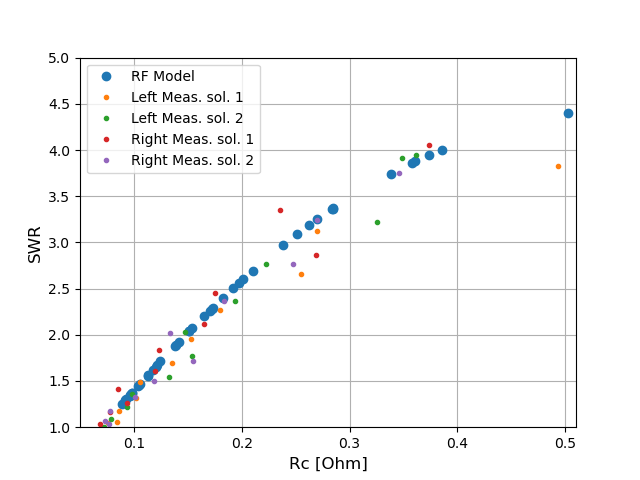

In [31]:
fig, ax = plt.subplots()
ax.plot(Rcs_vac[:,0], VSWR_vac[:,0], 'o', label='RF Model')

ax.plot(Rcs_exp_left1, VSWRs_exp_left1, '.', label='Left Meas. sol. 1')
ax.plot(Rcs_exp_left2, VSWRs_exp_left2, '.', label='Left Meas. sol. 2')
ax.plot(Rcs_exp_right1, VSWRs_exp_right1, '.', label='Right Meas. sol. 1')
ax.plot(Rcs_exp_right2, VSWRs_exp_right2, '.', label='Right Meas. sol. 2')

ax.set_ylim(1, 5)
ax.set_xlim(0.05, 0.51)
ax.set_xlabel('Rc [Ohm]', fontsize=12)
ax.set_ylabel('SWR', fontsize=12)
ax.grid(True)
ax.legend()

In [34]:
from IPython.core.display import HTML
def _set_css_style(css_file_path):
    """
    Read the custom CSS file and load it into Jupyter
    Pass the file path to the CSS file
    """
    styles = open(css_file_path, "r").read()
    s = '<style>%s</style>' % styles
    return HTML(s)

_set_css_style('custom.css')